In [327]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


import matplotlib 
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

font = {'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)


import astropy.units as u
from astropy.constants import R_sun, M_sun, G

from collections import defaultdict


from funcs.radii import (distance_from_parallax,
                         mann_radius_from_abs_Ks,
                         calculate_abs_Ks,
                         calculate_distmod)

# -----------------------------------------------------------
# TESS covers 73% of the sky, but only nearby stars, 
# some targets may saturate, especially from the ground
# give the star a 50/50 chance 
# - what TESS does not see which is not also galactic disk
mapfacility = defaultdict(lambda: 0.4)

mapping = [("Transiting Exoplanet Survey Satellite (TESS)",1.), ("Kepler",6.), ("K2",.5)]

for k,v in mapping:
    mapfacility[k] =v
    
def map_flares_disc_facility(facility):
    return mapfacility[facility]

# -----------------------------------------------------------

def TESS_flaring_fraction_estimate(radius):
    f0, f1, f2 = (radius > 1.), (radius > 0.59), (radius > 0.39)
    if f0:
        return 0.001 # F stars nearly never flare
    elif f1 & ~f0:
        return 0.01 #Tu et al. TESS sun-like star flare studies
    elif ~f1 & f2:
        return .1 #Guenther et al. K-earlyM stars in TESS
    elif ~f2:
        return .3 #Guenther et al. M stars in TESS

# -----------------------------------------------------------
    
maporbits = defaultdict(lambda: 13.)
# TESS covers 73% of the sky, but only nearby stars, 
# some targets may saturate, especially from the ground
# give the star a roughly 50/50 chance was observed 
# for a single sector, i.e. about 13 days on average

mapping = [("Transiting Exoplanet Survey Satellite (TESS)", 25.),
           ("Kepler", 80.),
           ("K2", 70.)]

for k,v in mapping:
    maporbits[k] =v    
    
def number_of_orbits_covered(orbper, facility):
    """
    Parameter:
    -------------
    orbper : float
        orbital period of star
    facility : str
        observing facility
        
    Return:
    -------
    number of orbits covered in observation by
    facility
    """
    obsdur = maporbits[facility]
    return obsdur / orbper

[Planetary Systems table](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS)

[Composite Table](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PSCompPars)

[column description](https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html)

In [328]:
# Composite Table of confirmed exoplanets
df = pd.read_csv("../data/PSCompPars_2021.01.08_01.59.05.csv",skiprows=318) # composite table
# df.columns.values

(350, 313)

In [430]:
# select only uncontroversial detections
sel = df[df.pl_controv_flag==0]
sel.shape, sel.groupby("hostname").first().shape

((4303, 313), (3209, 312))

In [432]:
_ = sel[["sy_plx","sy_dist","hostname"]]

# Use plx as minimal criterion
no_plx_no_dist = _[(_.sy_plx.isnull()) & (_.sy_dist.isnull())].groupby("hostname").first().shape[0]
no_plx_but_dist = _[(_.sy_plx.isnull()) & ~(_.sy_dist.isnull())].groupby("hostname").first().shape[0]
no_dist_but_plx =  _[~(_.sy_plx.isnull()) & (_.sy_dist.isnull())].groupby("hostname").first().shape[0]
no_plx_no_dist, no_plx_but_dist, no_dist_but_plx

(5, 154, 0)

In [331]:
d, derr = distance_from_parallax(sel[sel.sy_dist.isnull()].sy_plx, sel[sel.sy_dist.isnull()].sy_plxerr1)
    
sel.loc[sel.sy_dist.isnull(), "sy_dist"] = d
sel.loc[sel.sy_dist.isnull(), "sy_disterr1"] = derr

In [332]:
sel[sel.sy_dist.isnull()].shape[0] == no_plx_no_dist

True

In [417]:
subsel = sel[["pl_name","pl_orbsmax","sy_kmag","sy_kmagerr1",
              "sy_dist","sy_disterr1", "pl_orbper", "pl_orbeccen",
             "sy_snum","cb_flag", "hostname", "discoverymethod", "disc_facility",
             "st_rotp", "st_age", "st_vsin"]]
subsel.shape

(4303, 16)

In [419]:
dmod, dmoderr = calculate_distmod(subsel.sy_dist, subsel.sy_disterr1)

K, Kerr = calculate_abs_Ks(dmod, dmoderr, subsel.sy_kmag, subsel.sy_kmagerr1,)

r, rerr = mann_radius_from_abs_Ks(K, Kerr)
subsel["rad_rsun"] = r
subsel["rad_rsun_err"] = r
subsel["flaring_probability"] = (subsel.rad_rsun.apply(TESS_flaring_fraction_estimate) *
                                 subsel.disc_facility.apply(map_flares_disc_facility))

In [420]:
subsel[~subsel.pl_orbper.isnull()].shape[0], subsel[~subsel.rad_rsun.isnull()].shape[0]

(4166, 4191)

In [421]:
subsel["a_over_R"] = (subsel.pl_orbsmax.values * u.AU / (subsel.rad_rsun.values * R_sun)).decompose()
subsel["periastron_over_R"] = subsel.a_over_R * (1. - subsel.pl_orbeccen  )

In [428]:
hasorbperiod = ~subsel.pl_orbper.isnull()
haseccenvalue = ~subsel.pl_orbeccen.isnull()
subsel[hasorbperiod].shape[0], subsel[hasorbperiod  & haseccenvalue].shape[0]

(4166, 3837)

In [423]:
subsel[~subsel.st_rotp.isnull()].groupby("hostname").first().shape[0]

(247, 20)

In [425]:
subsel[(~subsel.st_vsin.isnull()) | (~subsel.st_rotp.isnull())].groupby("hostname").first().shape[0]

(1084, 20)

In [407]:
subsel[~subsel.st_age.isnull()].groupby("hostname").first().shape[0]

(2555, 19)

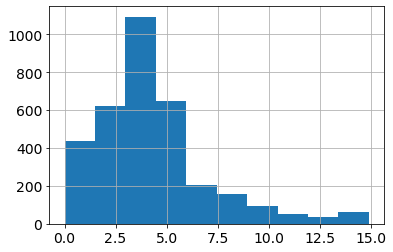

In [408]:
subsel.st_age.hist()

In [339]:
transiting = subsel.discoverymethod == "Transit"

50, 92-917 flares, 2042 stars, 32281 orbits, 3e-03 flares per orbit
30, 71-715 flares, 1773 stars, 31610 orbits, 2e-03 flares per orbit
20, 54-541 flares, 1399 stars, 29816 orbits, 2e-03 flares per orbit
10, 19-193 flares, 636 stars, 21073 orbits, 9e-04 flares per orbit
5, 3-34 flares, 98 stars, 8539 orbits, 4e-04 flares per orbit
3, 0-2 flares, 6 stars, 1233 orbits, 2e-04 flares per orbit


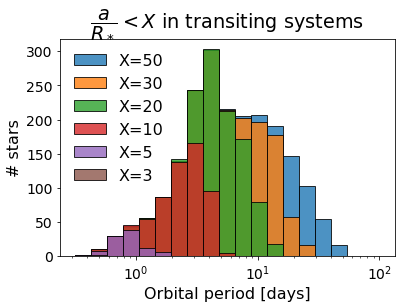

In [370]:
f5orlater = subsel.rad_rsun < 1.4 # F5 of later


for aoR in [50, 30, 20, 10, 5, 3]:
    
    closein = subsel.a_over_R < aoR
    _ = subsel[f5orlater & closein & transiting].groupby("hostname").first()
    orbits = _.apply(lambda x: number_of_orbits_covered(x.pl_orbper, x.disc_facility), axis=1).sum()
    flaresmin = _.flaring_probability.sum()
    flaresmax = flaresmin * 10
    print(f"{aoR}, {flaresmin:.0f}-"
          f"{flaresmax:.0f} flares, "
          f"{_.shape[0]} stars, "
          f"{orbits:.0f} orbits, "
          f"{flaresmin/orbits:.0e} flares per orbit")
    _.pl_orbper.hist(bins=np.logspace(-.5, 2, 20), grid=False, 
                     label=f"X={aoR}", alpha=.8, edgecolor="k")
    
plt.xscale("log")
plt.xlabel(r"Orbital period [days]")
plt.ylabel(r"# stars")
plt.legend(frameon=False)
plt.title(r"$\dfrac{a}{R_*}<X$ in transiting systems");

In [443]:
f5orlater = subsel.rad_rsun < 1.4 # F5 of later

est = {}
for aoR in [50, 30, 20, 10]:
    est[aoR] = {}
    closein = subsel.a_over_R < aoR
    for e in [.0,.1,.2,.3,.4,.5]:
        hashigheccen = subsel.pl_orbeccen >= e
        
        _ = subsel[f5orlater & closein & hashigheccen &transiting].groupby("hostname").first()
        orbits = _.apply(lambda x: number_of_orbits_covered(x.pl_orbper, x.disc_facility), axis=1).sum()
        flaresmin = _.flaring_probability.sum()
        flaresmax = flaresmin * 10
#         print(f"{aoR}, {flaresmin:.0f}-"
#               f"{flaresmax:.0f} flares, "
#               f"{_.shape[0]} stars, "
#               f"{orbits:.0f} orbits, "
#               f"{flaresmin/orbits:.0e} flares per orbit")
#         _.pl_orbper.hist(bins=np.logspace(-.5, 2, 20), grid=False, 
#                          label=f"X={aoR}", alpha=.8, edgecolor="k")
        est[aoR][e] = {"flaresmin" : flaresmin,
                       "flaresmax" : flaresmax,
                       "nstars" : _.shape[0],
                       "orbits" : int(orbits),
                       "flaresmin_per_orbit": flaresmin/orbits,
                       "flaresmax_per_orbit": flaresmax/orbits}

# plt.xscale("log")
# plt.xlabel(r"Orbital period [days]")
# plt.ylabel(r"# stars")
# plt.legend(frameon=False)
# plt.title(r"$\dfrac{a}{R_*}<X$ in transiting systems");

In [444]:
reform = {(outerKey, innerKey): values for outerKey, 
          innerDict in est.items() for innerKey, 
          values in innerDict.items()}
fermi = pd.DataFrame(reform).T.reset_index().rename(index=str, 
                                                    columns={"level_0":"max_a_over_R", "level_1":"min_e"})
fermi = fermi.set_index(["max_a_over_R","min_e"])

In [445]:
fermi.to_csv("../sample_selection_exoplanets.csv")

In [446]:
fermi[fermi.flaresmax>10.]

flaresmin  flaresmax  nstars   orbits  \
max_a_over_R min_e                                          
50           0.0      89.0506    890.506  1890.0  29944.0   
             0.1       6.4548     64.548   178.0   1644.0   
             0.2       3.3707     33.707    89.0    675.0   
             0.3       3.0388     30.388    53.0    312.0   
30           0.0      69.4731    694.731  1642.0  29371.0   
             0.1       4.8773     48.773   161.0   1586.0   
             0.2       3.2787     32.787    82.0    663.0   
             0.3       2.9618     29.618    49.0    307.0   
20           0.0      52.9352    529.352  1305.0  27791.0   
             0.1       2.1883     21.883   132.0   1415.0   
             0.2       1.2707     12.707    69.0    595.0   
10           0.0      18.6045    186.045   602.0  19762.0   

                    flaresmin_per_orbit  flaresmax_per_orbit  
max_a_over_R min_e                                            
50           0.0               0.002974             0.029738  
             0.1               0.003926             0.039258  
             0.2               0.004989             0.049895  
             0.3               0.009725             0.097250  
30           0.0               0.002365             0.023654  
             0.1               0.003074             0.030739  
             0.2               0.004939             0.049387  
             0.3               0.009641             0.096411  
20           0.0               0.001905             0.019048  
             0.1               0.001546             0.015465  
             0.2               0.002134             0.021342  
10           0.0               0.000941             0.009414

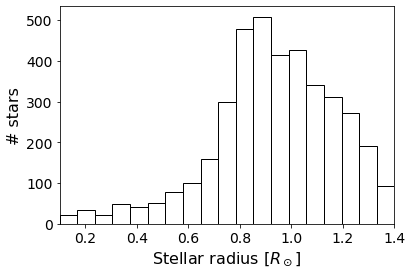

In [314]:
subsel.rad_rsun.hist(bins=np.linspace(.1, 1.4, 20), grid=False, facecolor="w", edgecolor="k")
plt.xlim(.1,1.4)
plt.xlabel(r"Stellar radius [$R_\odot$]")
plt.ylabel(r"# stars");

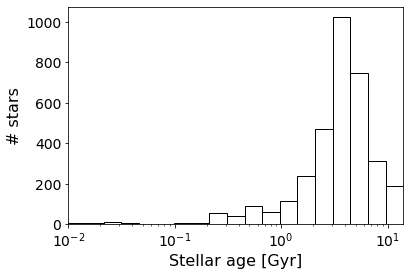

In [416]:
subsel.st_age.hist(bins=np.logspace(-2, np.log10(14), 20), grid=False, facecolor="w", edgecolor="k")
plt.xlim(.01,14)
plt.xscale("log")
plt.xlabel(r"Stellar age [Gyr]")
plt.ylabel(r"# stars");

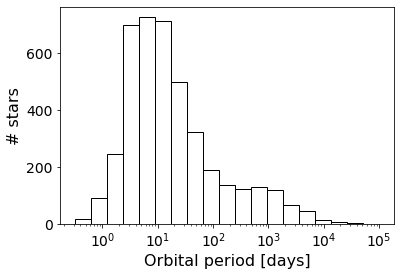

In [326]:
subsel.pl_orbper.hist(bins=np.logspace(-.5, 5, 20), grid=False, facecolor="w", edgecolor="k")
# plt.xlim(.1,1.4)
plt.xscale("log")
plt.xlabel(r"Orbital period [days]")
plt.ylabel(r"# stars");

In [185]:
hashigheccen = subsel.pl_orbeccen > .3
closein = subsel.periastron_over_R < 5.
subsel[f5orlater & closein & hashigheccen].groupby("hostname").first().flaring_probability.sum()

2.0399999999999996

In [127]:
binary = (subsel.sy_snum == 2)
not_circumbinary = (subsel.cb_flag == 0)

In [176]:
subsel[binary & not_circumbinary & closein & isdwarf].groupby("hostname").first().flaring_probability.sum()

2.3

In [195]:
subsel[isdwarf & closein & transiting].groupby("hostname").first().shape#flaring_probability.sum()

(67, 16)

In [202]:
subsel[subsel.pl_orbper.isnull()].discoverymethod.unique()

array(['Imaging', 'Disk Kinematics', 'Microlensing', 'Pulsar Timing'],
      dtype=object)

In [206]:
subsel.groupby("discoverymethod").pl_name.count()

discoverymethod
Astrometry                          1
Disk Kinematics                     1
Eclipse Timing Variations          14
Imaging                            48
Microlensing                      106
Orbital Brightness Modulation       1
Pulsar Timing                       7
Pulsation Timing Variations         2
Radial Velocity                   818
Transit                          3284
Transit Timing Variations          21
Name: pl_name, dtype: int64

In [214]:
subsel.groupby("disc_facility").pl_name.count()

disc_facility
Acton Sky Portal Observatory                       1
Anglo-Australian Telescope                        37
Apache Point Observatory                           1
Arecibo Observatory                                3
Atacama Large Millimeter Array (ALMA)              1
Bohyunsan Optical Astronomical Observatory        17
Calar Alto Observatory                            11
Cerro Tololo Inter-American Observatory            2
CoRoT                                             33
European Southern Observatory                      2
Fred Lawrence Whipple Observatory                  5
Gemini Observatory                                 9
HATNet                                            60
HATSouth                                          69
Haleakala Observatory                              2
Haute-Provence Observatory                        51
Hubble Space Telescope                             5
Infrared Survey Facility                           1
K2                              

# Backlog

In [210]:
# get a sense of stellar masses covered using Kepler #3
T = np.logspace(-1,2.5,100) * u.d

Rmax, Mmax = 0.559 * R_sun, 0.55 * M_sun
Rmin, Mmin = 0.199 * R_sun, 0.16 * M_sun
RmaxK, MmaxK = 0.817 * R_sun, 0.87 * M_sun
RmaxG, MmaxG = 1.18 * R_sun, 1.11 * M_sun

a3 = (T**2 * G * MmaxG / 4 / (np.pi**2))
amaxG_over_R = np.power((a3/RmaxG**3).decompose().value, 1/3)

a3 = (T**2 * G * MmaxK / 4 / (np.pi**2))
amaxK_over_R = np.power((a3/RmaxK**3).decompose().value, 1/3)

a3 = (T**2 * G * Mmax / 4 / (np.pi**2))
amax_over_R = np.power((a3/Rmax**3).decompose().value, 1/3)

a3 = (T**2 * G * Mmin / 4 / (np.pi**2))
amin_over_R = np.power((a3/Rmin**3).decompose().value, 1/3)

plt.figure(figsize=(9,7))
plt.scatter(subsel.pl_orbper,subsel.a_over_R, marker="x", c="grey")
plt.fill_between(T, amax_over_R, amin_over_R, facecolor="r", alpha=.3, label="M0-M5")
plt.fill_between(T, amaxK_over_R, amax_over_R, facecolor="orange", alpha=.3, label="K dwarfs")
plt.fill_between(T, amaxG_over_R, amaxK_over_R, facecolor="g", alpha=.3, label="G dwarfs")
plt.xlim(.1,130)
plt.ylim(2,130)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Orbital period [d]")
plt.ylabel(r"$a/R_*$")